In [1]:
from langchain_teddynote.messages import stream_graph
from langchain_core.tools import Tool
from langchain_core.vectorstores import VST
from datetime import datetime
import threading
import typing
import os
import sqlite3
from dotenv import load_dotenv
from operator import itemgetter

from langgraph.graph.state import CompiledStateGraph

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableWithMessageHistory, ConfigurableFieldSpec, RunnableConfig
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain_community.chat_message_histories import ChatMessageHistory, SQLChatMessageHistory
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import MongodbLoader
from typing import Annotated
from typing_extensions import TypedDict
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools.retriever import create_retriever_tool

from utils import generate_integer_id64, compare_dicts_sorted
from server.db import DB, get_mongo_collection
from server.db import get_mongo_connection_string
from server.logger import logger

from agentic_rag import grade_documents, AgentState, rewrite, generate, agent

load_dotenv()

vectorstore_dir = "../vectorstore"

# 모든 챗봇의 메타데이터를 가져와서 초기화.
chatbot_collection = get_mongo_collection(DB.NAME, DB.COLLECTION.CHATBOT)
chat_collection = get_mongo_collection(DB.NAME, DB.COLLECTION.CHANNEL.DATA)


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]

def load_chats(channel_ids:typing.Iterable[typing.Union[str, int]]):
    chats = {}
    for channel_id in channel_ids:
        # 채팅 데이터 collection에서, 참고하려는 채널에서 송수신된 모든 채팅의 채팅 id를 채널 id로 나누어서 저장.
        chats[channel_id] = [chat.get('id') for chat in chat_collection.find({"channelId": int(channel_id)})]
    return chats


# 클래스 정의가 완료되는 시점(클래스 선언 시점)에 미리 인스턴스를 생성하는 메타클래스.
class AutoCreateInstances(type):
    def __init__(cls, name, bases, dct):
        super().__init__(name, bases, dct)
        # _instances 변수를 초기화
        cls._instances = {}
        # 클래스가 생성되자마자 챗봇의 메타데이터를 다운로드, 챗봇 ID마다 인스턴스를 생성해서 등록
        for document in chatbot_collection.find():
            cls._instances[document.get('id')] = cls(bot_id=document.get('id'))

        logger.info(f"로드된 챗봇: {list(cls._instances.keys())}")
            
class Watson(metaclass=AutoCreateInstances):
    prompt_template = PromptTemplate.from_template(
        """You are an AI assistant helping an investigator trying to investigate a drug-selling channel. You are specialized in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
        Your primary mission is to answer questions based on provided context or chat history.
        Provided context is chat data collected from a Telegram channel where drugs are sold.
        Ensure your response is concise and directly addresses the question without any additional narration.
        
        ###
        
        Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.
        
        # Steps
        
        1. Carefully read and understand the context provided.
        2. Identify the key information related to the question within the context.
        3. Formulate a concise answer based on the relevant information.
        4. Ensure your final answer directly addresses the question.
        5. List the source of the answer in bullet points, which must be a url of the document, followed by brief part of the context. Omit if the source cannot be found.
        
        # Output Format:
        [Your final answer here, with numerical values, technical terms, jargon, and names in their original language]
        
        **Source**(Optional)
        - (Source of the answer, must be a url of the document, followed by brief part of the context. Omit if you can't find the source of the answer.)
        - (list more if there are multiple sources)
        - ...
        
        ###
        
        Remember:
        - It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
        - DO NOT use any external knowledge or information not present in the given materials.
        - If you can't find the source of the answer, you should answer that you don't know.
        
        ###
        
        # Here is the user's QUESTION that you should answer:
        {question}
        
        # Here is the CONTEXT that you should use to answer the question:
        {context}
        
        # Your final ANSWER to the user's QUESTION:"""
    )

    _instances = {}
    _session_history = {}  # 세션 기록을 저장할 딕셔너리
    _lock = threading.Lock()
    _sqlalchemy_connection_string = f"sqlite:///{os.path.dirname(vectorstore_dir)}/chats.db"
    _sqlite_connection_string = f"{os.path.dirname(vectorstore_dir)}/chats.db"
    
    error_msg_for_empty_data = "죄송합니다. 요청하신 채널의 데이터가 없거나, 아직 수집되지 않아 답변을 드릴 수 없습니다."
    GLOBAL = "global"
    MULTI = "multi"
    LOCAL = "local"
    
    memory = SqliteSaver(sqlite3.connect(_sqlite_connection_string, check_same_thread=False))

    def __new__(cls, bot_id:int=None, channel_ids:list=None, scope:str=None):
        """
            싱글톤 객체의 변형 구현.
            입력받은 channel id에 대응하는 watson 챗봇이 없을 경우에 한해,
            고유한 watson 객체를 새로 만들고 반환하는 동시에 _instances에 내부적으로 저장한다.

            만약 해당 channel id에 대응하는 챗봇이 이미 생성되었을 경우,
            그 챗봇을 반환한다.
        """
        with cls._lock:
            if not cls._instances.get(bot_id):
                new_bot = super().__new__(cls)
                if bot_id:
                    # 챗봇의 ID로 직접 챗봇을 호출할 때는, DB에 이미 해당 챗봇의 정보가 있음.
                    if channel_ids or scope:
                        logger.warning(f"참고할 채널 정보 또는 참고 범위를 입력했지만, 챗봇 ID를 입력했기 때문에 ID를 제외한 정보는 무시됩니다. "
                                       f"Chatbot ID: {bot_id}, Channel IDs: {channel_ids}, Scope: {scope}")
                    new_bot._bot_id = bot_id
                elif channel_ids and scope: # 챗봇이 참조하는 채널 정보로 챗봇을 호출할 때는 DB에 해당하는 챗봇이 있으면 로드. 없으면 생성.
                    if bot_id := cls._get_bot_id(cls, channel_ids, scope):
                        # 채널 정보에 해당하는 봇이 있다면 그 봇의 id를 기준으로 데이터베이스에서 로드한 정보를 가지고 생성하도록 요청.
                        new_bot._bot_id = bot_id
                    else:
                        # 채널 정보에 해당하는 봇이 없으면 bot_id를 입력하지 않고 채널 정보만 입력해서 새로운 봇을 생성하도록 요청.
                        new_bot._bot_id = None
                else:
                    raise ValueError(f"챗봇을 호출할 때 챗봇의 ID 또는 채널 ID 목록과 범위 둘 중 하나는 입력해야 하지만, 모두 입력되지 않았습니다.")

                cls._instances[bot_id] = new_bot

        return cls._instances[bot_id] # 이미 있거나 생성된 봇 반환.


    def _get_bot_id(self:typing.Type['Watson'], channel_ids:list, scope:str) -> typing.Optional[int]:
        """생성된 instance 중 참고하는 채널의 목록이 같으면 해당 봇의 ID를 반환하는 메서드."""
        for bot_id, bot_instance in self._instances.items():
            # global 챗봇은 하나만 유지하므로 scope가 global이면 global 챗봇만 찾고, 아닐 경우에만 channel ids를 비교한다.
            if scope == self.GLOBAL:
                if bot_instance.scope == scope:
                    return bot_id
            elif sorted(list(bot_instance.chats.keys())) == sorted(map(str, channel_ids)):
                return bot_id
        return None


    def __init__(self, bot_id:int=None, channel_ids:list[int]=None, scope:str=None):
        try:
            with self._lock:
                # 이미 객체가 초기화되어 있을 경우(chats가 있고, None이 아님), 객체를 초기화하지 않고 벡터스토어만 업데이트한 후 종료.
                # 만약 chats가 아닌 _bot_id를 기준으로 한다면, __new__에서 _bot_id를 초기화한 후에 넘어오기 때문에 항상 참이 된다.
                # 때문에 chats를 기준으로 해야 함.
                if getattr(self, "chats", None):
                    self._update_vectorstore()
                    return

                logger.debug(f"메모리에 새로운 챗봇을 로드합니다. Chatbot ID: {self._bot_id}")
                if self._bot_id: # bot_id가 입력되었을 경우: 이미 DB에 정보가 저장되어 있으므로 로드.
                    bot_info = chatbot_collection.find_one({"id": self._bot_id})
                    # 데이터베이스에 id가 없으면 아직 생성하지 않은 챗봇에 접근하는 것이므로 오류.
                    if not bot_info:
                        raise KeyError(f"생성한 적이 없는 ID로 챗봇을 불러오려고 시도했습니다. Chatbot ID: {bot_id}")
                    self.chats, self.scope = bot_info.get("chats"), bot_info.get("scope")
                else:
                    if type(channel_ids) is not list or not all([isinstance(_id, int) for _id in channel_ids]):
                        raise TypeError(f"Parameter 'channel_ids' must be list[int].")

                    self._bot_id = generate_integer_id64(existing_ids=self._instances.keys())
                    self.scope = scope
                    self.chats = {}
                    for channel_id in channel_ids:
                        # 채팅 데이터 collection에서, 참고하려는 채널에서 송수신된 모든 채팅의 채팅 id를 채널 id로 나누어서 저장.
                        # 이 때, scope가 "global"이라면 모든 채널 ID를 불러와서 저장.
                        self.chats[str(channel_id)] = [chat.get('id') for chat in chat_collection.find(
                            {} if self.scope == self.GLOBAL else {"channelId": channel_id}
                        )]
                    logger.debug(f"새로운 챗봇을 생성했습니다. Chatbot ID: {self._bot_id}")

                self._update_db() # MongoDB에서 현재 챗봇의 정보 업데이트 (없을 경우 신규 생성)

                self._embedding = OpenAIEmbeddings()  # 임베딩(Embedding) 생성
                self._llm = ChatOpenAI(model_name="gpt-4o", temperature=0)  # 언어모델(LLM) 생성

                self._vectorstore:typing.Optional[VST] = None
                self._chain = None
                self.graph:CompiledStateGraph = None
                # watson/vectorstore/<bot id> 위치에 벡터스토어 저장.
                self._vectorstore_path = os.path.join(vectorstore_dir, str(self._bot_id))
                self._update_vectorstore()

        except Exception as e:
            logger.error(f"An error occurred while initializing instance: {e}")


    def _update_vectorstore(self):
        try:
            """
                다음의 경우에 RAG vectorstore를 재생성.
                1. 로컬에 저장된 벡터스토어가 없을 때
                2. MongoDB로 확인한 바, 현재 챗봇의 근거 데이터가 없을 때.
                3. MongoDB로 확인한 바, 현재 챗봇의 근거 데이터가 되는 채팅 ID 목록이 채널의 채팅 ID 목록과 서로 다를 때
            """
            if not os.path.exists(self._vectorstore_path):
                logger.info(f"There is no local vectorstore. Create vectorstore. (Local Path: {self._vectorstore_path})")
                self._build_vectorstore()  # MongoDB에서 채팅 데이터를 불러와서 vectorstore 재생성
            elif not self.chats:
                logger.info(f"There is no references for chatbot. Create vectorstore. (Local Path: {self._vectorstore_path})")
                self._build_vectorstore()
            elif not compare_dicts_sorted(self.chats, newest_chats:=load_chats(self.chats.keys())):
                self.chats = newest_chats
                logger.info(f"The reference chats for chatbot is different from chats of the channel. Rebuild Vectorstore. "
                            f"(Local Path: {self._vectorstore_path})")
                self._build_vectorstore()
            else:
                logger.info(f"The reference data of local vectorstore is same with channel data. Reuse local vectorstore. "
                            f"(Local Path: {self._vectorstore_path})")
                self._load_vectorstore()  # 챗봇이 참조 중인 채팅이 현재 채널의 채팅과 일치하고, 그 벡터스토어가 로컬에 저장되어 있을 때 불러옴.

            self._build_graph()
        except Exception as e:
            logger.error(f"An error occurred while updating vectorstore: {e}")

    def _load_vectorstore(self):
        """
            Notice for allow_dangerous_deserialization parameters of FAISS.load_local():

            The de-serialization relies on loading a pickle file.
            Pickle files can be modified to deliver a malicious payload
            that results in execution of arbitrary code on your machine.
            You will need to set `allow_dangerous_deserialization` to `True` to enable deserialization.
            If you do this, make sure that you trust the source of the data.
            For example, if you are loading a file that you created, and know that no one else has modified the file,
            then this is safe to do.
            Do not set this to `True` if you are loading a file from an untrusted source
            (e.g., some random site on the internet.).
        """
        try:
            # load_vectorstore가 호출되었다면 변경사항이 없다는 뜻이므로, 객체에 저장된 vectorstore가 있다면 재사용 가능
            if not self._vectorstore:
                self._vectorstore = FAISS.load_local(self._vectorstore_path, self._embedding, allow_dangerous_deserialization=True)
        except Exception as e:
            logger.error(f"An error occurred while loading vectorstore from local: {e}")

    def _save_vectorstore(self):
        try:
            self._vectorstore.save_local(self._vectorstore_path)
        except Exception as e:
            logger.error(f"An error occurred while saving vectorstore to local: {e}")


    def _update_db(self):
        try:
            if not chatbot_collection.find_one({"id": self._bot_id}):
                chatbot_collection.insert_one({
                    "id": self._bot_id,
                    "updatedAt": datetime.now(),
                    "chats": {},
                    "scope": None,
                })
            chatbot_collection.update_one({"id": self._bot_id},
                                          {"$set": {
                                              "updatedAt": datetime.now(),
                                              "chats": self.chats,
                                              "scope": self.scope,
                                          }})
        except Exception as e:
            logger.error(f"An error occurred while updating chatbot metadata at MongoDB: {e}")


    def _build_vectorstore(self):
        try:
            channel_ids = list(map(int, self.chats.keys())) # chats의 key가 str 형으로 저장되어 있기 때문에, int로 변환한 뒤 검색
            # 단계 1: 문서 로드(Load Documents)
            logger.debug(f"Loading chat data from MongoDB. Channel IDs: {channel_ids}, scope: {self.scope}")
            loader = MongodbLoader(
                connection_string=get_mongo_connection_string(),
                db_name=DB.NAME,
                collection_name=DB.COLLECTION.CHANNEL.DATA,
                filter_criteria={} if self.scope == "global" else {
                    "channelId": { "$in": channel_ids }
                },  # 데이터베이스에서 조회할 기준 (쿼리)
                field_names=("text",),
                metadata_names=("id", "timestamp", "views", "url"),  # 메타데이터로 지정할 필드 목록
            )
            docs = loader.load()
            if not docs:
                self._vectorstore = None
                logger.warning(f"There is no channel data found at DB for the bot. Channel IDs: {channel_ids}, scope: {self.scope}")
                return

            # 단계 2: 문서 분할(Split Documents)
            logger.debug(f"Splitting loaded chat documents from MongoDB. Channel IDs: {channel_ids}, scope: {self.scope}")
            text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
            split_documents = text_splitter.split_documents(docs)

            # 단계 3: 임베딩(Embedding) 생성
            # 임베딩을 생성한다.
            # embedding = OpenAIEmbeddings()  # -> self._embedding 으로 저장한다음 바로 참조하기 때문에 생략됨

            # 단계 4: DB 생성(Create DB) 및 저장
            # 벡터스토어를 생성하고, 저장한다.
            logger.debug(f"Creating and Saving the vectorstore. Channel IDs: {channel_ids}, scope: {self.scope}")
            self._vectorstore = FAISS.from_documents(documents=split_documents, embedding=self._embedding)
            self._save_vectorstore()

            # chatbot collection에서 chatIds를 수집된 채팅의 ID로 업데이트
            logger.debug(f"Updating chatbot metadata. Channel IDs: {channel_ids}, scope: {self.scope}")
            self._update_db()
        except Exception as e:
            logger.error(f"An error occurred while building vectorstore: {e}")
            
    
    def _build_graph(self):
        if not self._vectorstore:
            return
        
        ########## 2. 도구 정의 및 바인딩 ##########
        # 도구 초기화
        retriever_tool = create_retriever_tool(
            retriever=self._vectorstore.as_retriever(search_kwargs={"k": 6}), # 6개의 문서 검색,
            name="retrieve_chats_in_telegram_channel",
            description="Searches and returns a few chat messages from the Telegram channel that are most relevant to the question.",
            document_prompt=PromptTemplate.from_template(
                "<document><context>{page_content}</context><metadata><timestamp>{timestamp}</timestamp><url>{url}</url><views>{views}</views></metadata></document>"
            ),
        )
        
        # AgentState 기반 상태 그래프 워크플로우 초기화
        workflow = StateGraph(AgentState)
        
        
        workflow.add_node("agent", lambda state: agent(state, retriever_tool)) # 에이전트 노드 
        retrieve = ToolNode([retriever_tool])
        workflow.add_node("retrieve", retrieve)  # 검색 노드
        workflow.add_node("rewrite", rewrite)  # 질문 재작성 노드
        workflow.add_node("generate", generate)  # 관련 문서 확인 후 응답 생성 노드
        
        # 시작점에서 에이전트 노드로 연결
        workflow.add_edge(START, "agent")        
        workflow.add_edge("agent", "retrieve")
        
        # 액션 노드 실행 후 처리될 엣지 정의
        workflow.add_conditional_edges(
            "retrieve",
            # 문서 품질 평가
            grade_documents,
        )
        workflow.add_edge("generate", END)
        workflow.add_edge("rewrite", "agent")
        
        self.graph = workflow.compile(checkpointer=self.memory)

    
    def clear_message_history(self):
        """
        주어진 세션(session_id)에 해당하는 메시지 히스토리를 삭제한다.

        Parameters:
            connection (sqlite3.Connection): SQLite 데이터베이스 연결 객체
            table_name (str): 메시지 히스토리가 저장된 테이블 이름
            conversation_id (str): 삭제할 메시지 히스토리의 세션 ID
        """
        connection = sqlite3.connect(self._sqlite_connection_string)
        cursor = connection.cursor()
        cursor.execute(f"DELETE FROM checkpoints WHERE thread_id = ?", (self._bot_id,))
        cursor.execute(f"DELETE FROM writes WHERE thread_id = ?", (self._bot_id,))
        connection.commit()
        cursor.close()


    # 체인 실행(Run Chain)
    # 문서에 대한 질의를 입력하고, 답변을 출력한다.
    def ask(self, question: str):
        # graph가 있으면 graph agent를 실행하고 답변을 반환. chain이 없으면 에러 메세지 반환.
        if not self.graph:
            return self.error_msg_for_empty_data
        inputs = {
            "messages": [("user", question)],
            "question": question,
            "prompt": self.prompt_template,
        }
        config = RunnableConfig(
            recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
            # 스레드 ID 설정. 현재는 봇의 ID로 고정이기 때문에 봇 하나당 하나의 대화 스레드만 유지할 수 있음.
            configurable={"thread_id": self._bot_id},  
        )
        # 그래프 실행
        return self.graph.invoke(inputs, config=config)['messages'][-1].content

PROJECT ROOT: C:\Users\Sapphire\Documents\Gachon\P_Project\Retriever_backend


[2025-02-18 20:43:22.312]  DEBUG  from watson.py in \Modules\watson: 메모리에 새로운 챗봇을 로드합니다. Chatbot ID: 955956081214299624
[2025-02-18 20:43:22.623]  INFO  from watson.py in \Modules\watson: The reference data of local vectorstore is same with channel data. Reuse local vectorstore. (Local Path: C:\Users\Sapphire\Documents\Gachon\P_Project\Retriever_backend\Modules\watson\vectorstore\955956081214299624)
[2025-02-18 20:43:22.653]  DEBUG  from watson.py in \Modules\watson: 메모리에 새로운 챗봇을 로드합니다. Chatbot ID: 1490307528433254824
[2025-02-18 20:43:22.729]  INFO  from watson.py in \Modules\watson: The reference data of local vectorstore is same with channel data. Reuse local vectorstore. (Local Path: C:\Users\Sapphire\Documents\Gachon\P_Project\Retriever_backend\Modules\watson\vectorstore\1490307528433254824)
[2025-02-18 20:43:22.731]  INFO  from watson.py in \Modules\watson: 로드된 챗봇: [955956081214299624, 1490307528433254824]
[2025-02-18 20:43:22.816]  DEBUG  from 3099655262.py in C:\Users\Sapphire\

In [2]:
watson = Watson(
    channel_ids=[1890652954],
    scope='local'
)

[2025-02-18 20:43:23.117]  DEBUG  from 3099655262.py in C:\Users\Sapphire\AppData\Local\Temp\ipykernel_28928: 메모리에 새로운 챗봇을 로드합니다. Chatbot ID: 955956081214299624
[2025-02-18 20:43:23.199]  INFO  from 3099655262.py in C:\Users\Sapphire\AppData\Local\Temp\ipykernel_28928: The reference data of local vectorstore is same with channel data. Reuse local vectorstore. (Local Path: ../vectorstore\955956081214299624)


In [3]:
watson.clear_message_history()

In [4]:
print(watson.ask("이 채널에서 판매되는 마약의 종류는?"))

==== [DECISION: DOCS RELEVANT] ====
이 채널에서 판매되는 마약의 종류는 다음과 같습니다:
- 아프간 쿠쉬
- 아이스 (3종류)
- 떨액
- S케이
- 브액
- 북한산 빙두
- 멕시코산 퓨어 원석 케타민

**Source**
- https://t.me/frozen_talk/69: "아프간 쿠쉬"
- https://t.me/frozen_talk/169: "아이스(3종류)", "떨액", "S케이", "브액"
- https://t.me/frozen_talk/224: "북한산 빙두"
- https://t.me/frozen_talk/250: "멕시코산 퓨어 원석 케타민"


In [9]:
watson.ask("이 채널에서 판매되는 마약의 가격은?")


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
이 채널에서 판매되는 마약의 가격 정보는 다음과 같습니다:

- 아프간 쿠쉬: 5지 55만, 10지 95만 (7월부터 가격 인상 예정)

**Source**
- https://t.me/frozen_talk/69 - 아프간 쿠쉬 가격 정보

In [22]:
watson.ask("내가 방금 전에 한 질문과 그에 대한 답변은 뭐였지?")


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
당신이 방금 전에 한 질문은 "이 채널에서 마약이 판매되는 지역은?"이었고, 그에 대한 답변은 다음과 같았습니다:

이 채널에서 마약이 판매되는 지역은 다음과 같습니다:
- 부산
- 광주
- 창원
- 울산
- 강서
- 천안
- 강남
- 인천
- 수원
- 일산
- 대구

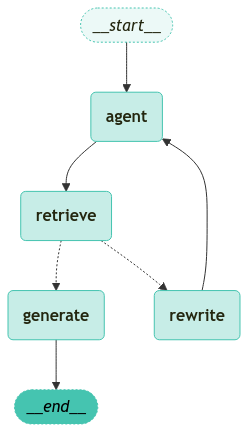

In [4]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(watson.graph)

In [4]:
watson._vectorstore.as_retriever(search_kwargs={"k": 6}).invoke(input="지역")

[Document(id='5d74f6e0-b522-4cc4-98ba-cba02a9abb1c', metadata={'id': 108, 'timestamp': datetime.datetime(2023, 7, 29, 6, 5, 37), 'chats': '', 'views': 1005, 'url': 'https://t.me/frozen_talk/108', 'database': 'retriever-jisung', 'collection': 'channel_data'}, page_content='-떨 부산 및 광주만 가능\n 전 지역 품절\n(재입고시 공지예정)'),
 Document(id='bb6e8f07-ef02-4df7-afd1-1d279a32288f', metadata={'id': 44, 'timestamp': datetime.datetime(2023, 5, 15, 12, 33, 31), 'chats': '', 'views': 1069, 'url': 'https://t.me/frozen_talk/44', 'database': 'retriever-jisung', 'collection': 'channel_data'}, page_content='강서 지역 좌표 추가됐습니다\n그동안 강남이 멀어서 구매\n못하셨던 분들 많이 찾아주세요!'),
 Document(id='4bdbdffd-a278-41ed-8144-b2505758abf9', metadata={'id': 224, 'timestamp': datetime.datetime(2024, 6, 1, 12, 55, 7), 'chats': '', 'views': 2191, 'url': 'https://t.me/frozen_talk/224', 'database': 'retriever-jisung', 'collection': 'channel_data'}, page_content='-북한산 빙두\n소량 입고 완료\n품절 금방되니 빠르게 가져가세요\n좌표지역 개별문의'),
 Document(id='3efc75a4-425f-4c2b-a8